In [2]:
import io
import math
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import matplotlib.pyplot as plt

# from tqdm import tqdm
from tqdm.notebook import tqdm
from time import sleep
from timeit import default_timer as timer

data = pd.read_csv('./data/rev_train_256.csv', header=None, sep=';')
test_data = pd.read_csv('./data/rev_val_256.csv', header=None, sep=';')

In [3]:
class ReverseStringsDataset(Dataset):
    def __init__(self, data):
        super(self.__class__, self).__init__()
        self.inputs = data[0].values
        self.outputs = data[1].values
        
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx].strip(), self.outputs[idx].strip()
    
dataset = ReverseStringsDataset(data)

def yield_tokens(dataset):
    for i in range(len(dataset)):
        yield dataset[i][0].strip().split() + dataset[i][1].strip().split()        
        
vocab = build_vocab_from_iterator(yield_tokens(dataset), 
                                      specials=['<unk>', '<pad>', '<start>', '<eos>'],
                                      special_first=True)
print("vocabulary", len(vocab))
vocab.get_stoi()

vocabulary 14


{'i': 12,
 'j': 11,
 'e': 4,
 'b': 6,
 '<unk>': 0,
 '<start>': 2,
 '<pad>': 1,
 'a': 13,
 'g': 7,
 'f': 10,
 'h': 5,
 'd': 8,
 '<eos>': 3,
 'c': 9}

In [4]:
def vocab_func(vocab):
    def func(tok_iter):
        return [vocab[tok] for tok in tok_iter]
    return func

start_idx = vocab['<start>']
eos_idx = vocab['<eos>']
pad_idx = vocab['<pad>']

def totensor(dtype):
    def func(ids_list):
        return torch.cat((torch.tensor([start_idx]).to(dtype), 
                          torch.tensor(ids_list).to(dtype), 
                          torch.tensor([eos_idx]).to(dtype)))  
    return func    

def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

transforms = sequential_transforms(lambda x: x.split(), vocab_func(vocab), totensor(torch.long))

# emb_size = len(vocab)
emb_size = 16
batch_size = 32
tgt_vocab_size = len(vocab)

# function to collate data samples into batch tesors
def collate_fn(batch):
    input_batch, output_batch = [], []
    for i, o in batch:
#         input_batch.append(torch.nn.functional.one_hot(transforms(i), num_classes=emb_size))
#         output_batch.append(torch.nn.functional.one_hot(transforms(o), num_classes=emb_size))
        input_batch.append(transforms(i))
        output_batch.append(transforms(o))
        
    input_batch = pad_sequence(input_batch, padding_value=pad_idx)
    output_batch = pad_sequence(output_batch, padding_value=pad_idx)
    return input_batch, output_batch

dataset = ReverseStringsDataset(data)
train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)
next(iter(train_dataloader))

(tensor([[ 2,  2,  2,  ...,  2,  2,  2],
         [ 6,  7,  9,  ..., 13, 10,  5],
         [11, 13, 13,  ...,  8,  4,  5],
         ...,
         [11, 13, 12,  ...,  6, 11,  5],
         [ 7, 11, 11,  ...,  9,  6, 12],
         [ 3,  3,  3,  ...,  3,  3,  3]]),
 tensor([[ 2,  2,  2,  ...,  2,  2,  2],
         [ 7, 11, 11,  ...,  9,  6, 12],
         [11, 13, 12,  ...,  6, 11,  5],
         ...,
         [11, 13, 13,  ...,  8,  4,  5],
         [ 6,  7,  9,  ..., 13, 10,  5],
         [ 3,  3,  3,  ...,  3,  3,  3]]))

torch.Size([500, 16])


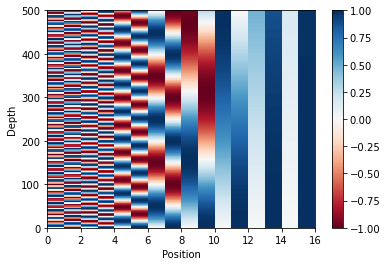

In [5]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float = 0.1,
                 maxlen: int = 500):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token: Tensor):
        token_embedding = torch.nn.functional.one_hot(token, num_classes=emb_size)
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

pe = PositionalEncoding(emb_size, dropout=0.1)
img = pe.pos_embedding.permute(1,0,2).squeeze()
print(img.shape)

plt.pcolormesh(img, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Seq2SeqTransformer(nn.Module):
    def __init__(self, emb_size: int, tgt_vocab_size):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = nn.Transformer(d_model=emb_size)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.positional_encoding = PositionalEncoding(emb_size)

    def forward(self,
                src: Tensor,
                tgt: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(src)
        tgt_emb = self.positional_encoding(tgt)
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(src), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(tgt), memory, tgt_mask)

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == pad_idx).transpose(0, 1)
    tgt_padding_mask = (tgt == pad_idx).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

transformer = Seq2SeqTransformer(emb_size, tgt_vocab_size)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)

# optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001)

In [7]:
def train_epoch(model, optimizer, epoch):
    model.train()
    losses = 0

    dataset = ReverseStringsDataset(data)
    train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)
    
    i = 0
    
    with tqdm(train_dataloader, unit="batch") as tepoch:

        tepoch.set_description(f"Epoch {epoch}")
        
        for src, tgt in tepoch:
            src = src.to(device)
            tgt = tgt.to(device)
            
            tgt_input = tgt[:-1, :]

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

            logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

            optimizer.zero_grad()

            tgt_out = tgt[1:, :]
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            loss.backward()

            optimizer.step()
            losses += loss.item()

            i += 1
            tepoch.set_postfix(loss=(losses / i))

    return losses / len(train_dataloader)

def evaluate(model):
    model.eval()
    losses = 0

    dataset = ReverseStringsDataset(test_data)
    val_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

# function to generate output sequence using greedy algorithm 
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == eos_idx:
            break
    return ys

# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = transforms(src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=start_idx).flatten()
    return " ".join(vocab.lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<start>", "").replace("<eos>", "").strip()

In [8]:
test_dataset = ReverseStringsDataset(test_data)

for epoch in range(1, 500):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, epoch)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    
    input = test_dataset[0][0]
    output = test_dataset[0][1]
    prediction = translate(transformer, input)
    print("input")
    print(input)
    print("output")
    print(output)
    print("prediction")
    print(prediction)
    print(output == prediction, len(output), len(prediction))
    
    from timeit import default_timer as timer

# for epoch in range(1, 50):
#     start_time = timer()
#     train_loss = train_epoch(transformer, optimizer, epoch)
#     end_time = timer()
#     val_loss = evaluate(transformer)
#     print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

  0%|          | 0/313 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [ ]:
dataset = ReverseStringsDataset(test_data)
print(dataset[0][0])
output = dataset[0][1]
prediction = translate(transformer, dataset[0][0])
print("output")
print(output)
print(prediction)
print(output == prediction, len(output), len(prediction))